In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

In [2]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3641 (delta 4), reused 6 (delta 2), pack-reused 3629
Receiving objects: 100% (3641/3641), 632.97 MiB | 46.85 MiB/s, done.
Resolving deltas: 100% (1446/1446), done.
Checking out files: 100% (1174/1174), done.


In [3]:
df = pd.read_csv('./covid-chestxray-dataset/metadata.csv')
selected_df = df[df.finding=="Pneumonia/Viral/COVID-19"]
selected_df = selected_df[(selected_df.view == "AP") | (selected_df.view == "PA")]
selected_df.head(2)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [4]:
os.makedirs('./COVID19-DATASET/train/covid19')
os.makedirs('./COVID19-DATASET/train/normal')

In [18]:
os.makedirs('./COVID19-DATASET/train/pneumonia')

In [19]:
COVID_PATH = './COVID19-DATASET/train/covid19'
NORMAL_PATH = './COVID19-DATASET/train/normal'
PNEUMONIA_PATH = './COVID19-DATASET/train/pneumonia'

In [6]:
540404/(177232+540404)

0.7530335713370009

In [7]:
images = selected_df.filename.values.tolist()
count=0
for image in images:
  count=count+1
  shutil.copy(os.path.join('./covid-chestxray-dataset/images', image), os.path.join(COVID_PATH, image))
print(count)

342


In [8]:
! pip install -q kaggle #https://www.kaggle.com/general/74235

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"light100bc","key":"e2f30412fb3ed2c27ed0f6994ae12d39"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [12]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 72.1MB/s]
100% 2.29G/2.29G [00:29<00:00, 82.6MB/s]


In [ ]:
! mkdir ./input
! unzip chest-xray-pneumonia.zip -d input

In [14]:
! ls ./input/chest_xray/train #debug #use normal in this data set

NORMAL	PNEUMONIA


In [15]:
# for image in os.listdir('../input/chest-xray-pneumonia/chest_xray/train/NORMAL')[:300]:
#     shutil.copy(os.path.join('../input/chest-xray-pneumonia/chest_xray/train/NORMAL', image), os.path.join(NORMAL_PATH, image))
for image in os.listdir('./input/chest_xray/train/NORMAL')[:300]:
    shutil.copy(os.path.join('./input/chest_xray/train/NORMAL', image), os.path.join(NORMAL_PATH, image))

In [20]:
for image in os.listdir('./input/chest_xray/train/PNEUMONIA')[:300]:
    shutil.copy(os.path.join('./input/chest_xray/train/PNEUMONIA', image), os.path.join(PNEUMONIA_PATH, image))

In [21]:
DATA_PATH = './COVID19-DATASET/train'

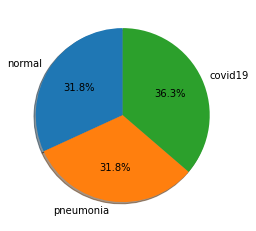

In [22]:
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

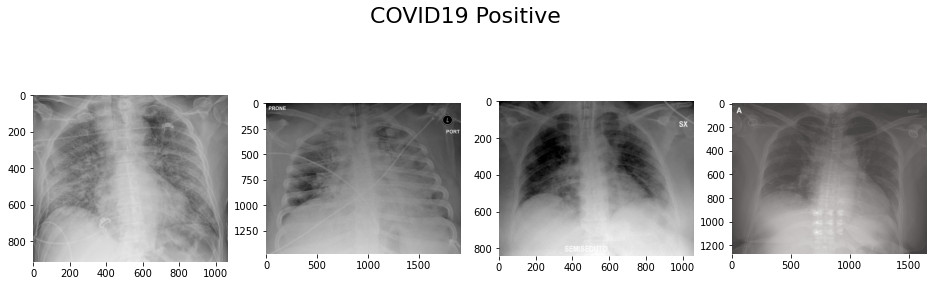

In [23]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

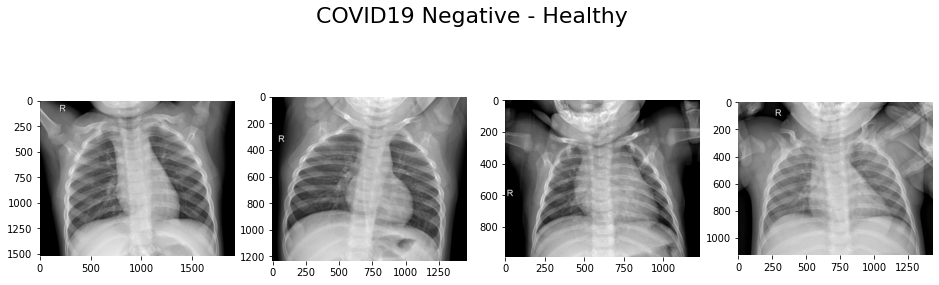

In [26]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

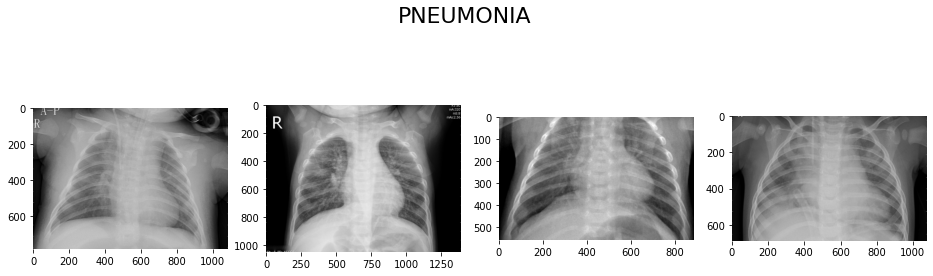

In [27]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("PNEUMONIA", size=22)
img_paths = os.listdir(PNEUMONIA_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(PNEUMONIA_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [29]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [30]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid19', 'normal', 'pneumonia']


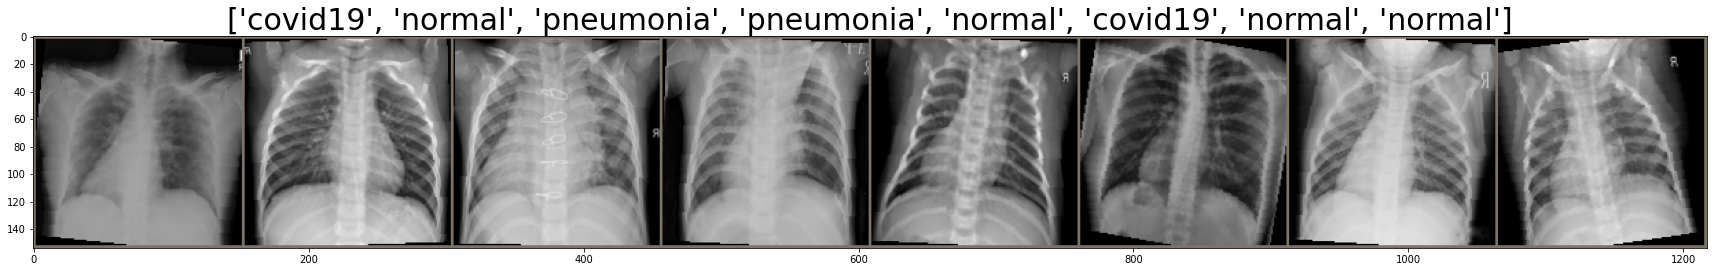

In [31]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [32]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [33]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [34]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6956931


In [142]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    ###train-valid loss
    train_loss_list=[]
    valid_loss_list=[]
    train_epoch_loss_list=[]
    valid_epoch_loss_list=[]
    best_epoch=-1

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))

                ###
                if phase == 'val':
                    valid_loss_list.append(loss.item() * inputs.size(0))
                else:
                    train_loss_list.append(loss.item() * inputs.size(0))


            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
                valid_epoch_loss_list.append(epoch_loss)
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                train_epoch_loss_list.append(epoch_loss)

            

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                ### record the best one 
                best_epoch=epoch

    

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    ### train-valid graph
    plt.title('SGD loss')
    plt.plot(valid_epoch_loss_list,label = "valid")
    plt.plot(train_epoch_loss_list,label = "train")
    plt.legend()
    plt.show()

    plt.title('epoch valid avg loss')
    plt.plot(valid_loss_list,label = "valid")
    plt.show()

    plt.title('epoch train avg loss')
    plt.plot(train_loss_list,label = "train")
    plt.legend()
    print("best epoch: ",best_epoch)

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

    

In [129]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 1/10
----------


train Loss: 0.3888 | train Accuracy: 0.8488


val Loss: 0.2244 | val Accuracy: 0.9255 | Kappa Score: 0.8810
Val loss Decreased from inf to 0.2244 
Saving Weights... 
Epoch 2/10
----------


train Loss: 0.3826 | train Accuracy: 0.8369


val Loss: 0.2176 | val Accuracy: 0.9202 | Kappa Score: 0.8632
Val loss Decreased from 0.2244 to 0.2176 
Saving Weights... 
Epoch 3/10
----------


train Loss: 0.3561 | train Accuracy: 0.8607


val Loss: 0.2232 | val Accuracy: 0.9149 | Kappa Score: 0.8659
Epoch 4/10
----------


train Loss: 0.3815 | train Accuracy: 0.8475


val Loss: 0.2184 | val Accuracy: 0.9255 | Kappa Score: 0.8844
Epoch 5/10
----------


train Loss: 0.4308 | train Accuracy: 0.8263


val Loss: 0.2065 | val Accuracy: 0.9309 | Kappa Score: 0.8853
Val loss Decreased from 0.2176 to 0.2065 
Saving Weights... 
Epoch 6/10
----------


train Loss: 0.4142 | train Accuracy: 0.8210


val Loss: 0.2228 | val Accuracy: 0.9255 | Kappa Score: 0.8677
Epoch 7/10
----------


train Loss: 0.4006 | train Accuracy: 0.8342


val Loss: 0.2459 | val Accuracy: 0.9202 | Kappa Score: 0.8737
Epoch 8/10
----------


train Loss: 0.3816 | train Accuracy: 0.8501


val Loss: 0.2025 | val Accuracy: 0.9309 | Kappa Score: 0.8792
Val loss Decreased from 0.2065 to 0.2025 
Saving Weights... 
Epoch 9/10
----------


train Loss: 0.3846 | train Accuracy: 0.8369


val Loss: 0.2216 | val Accuracy: 0.9096 | Kappa Score: 0.8386
Epoch 10/10
----------


train Loss: 0.4011 | train Accuracy: 0.8528


val Loss: 0.2361 | val Accuracy: 0.9096 | Kappa Score: 0.8522
Training complete in 5m 31s
Best val loss: 0.2025


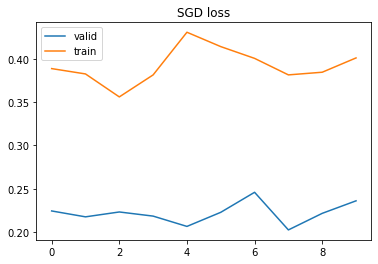

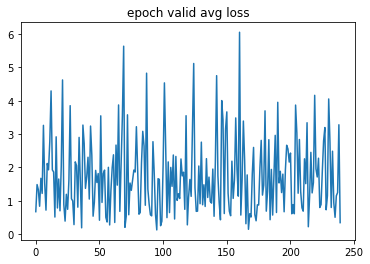

best epoch:  7


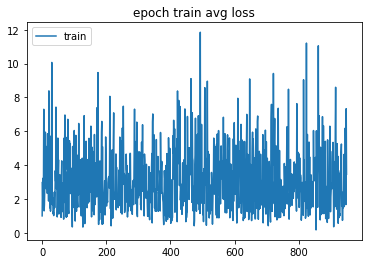

In [143]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

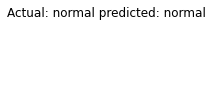

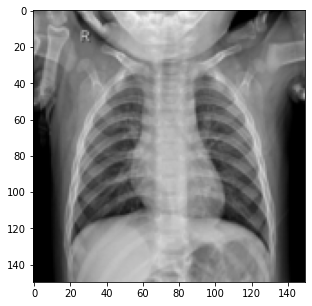

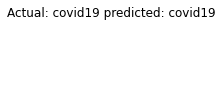

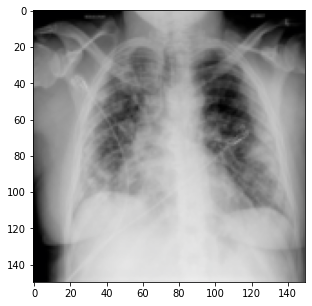

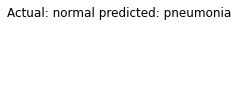

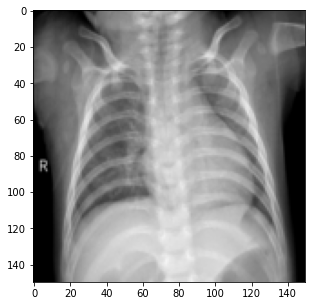

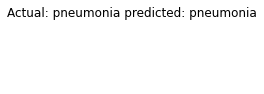

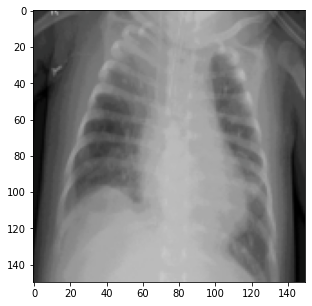

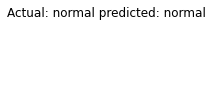

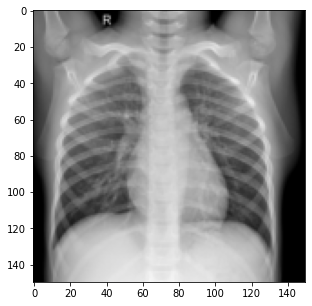

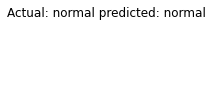

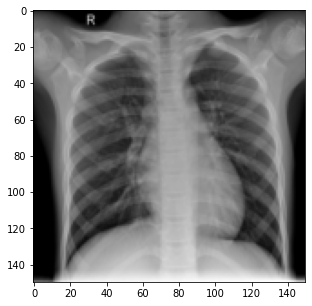

In [40]:
visualize_model(base_model)
plt.show()

In [41]:
os.makedirs('./COVID19-DATASET/test/covid19')
os.makedirs('./COVID19-DATASET/test/normal')
os.makedirs('./COVID19-DATASET/test/pneumonia')

In [42]:
! kaggle datasets download tawsifurrahman/covid19-radiography-database

 98% 726M/745M [00:03<00:00, 208MB/s]
100% 745M/745M [00:03<00:00, 200MB/s]


In [ ]:
! mkdir ./input
! unzip covid19-radiography-database.zip -d input

In [109]:
!ls ./COVID19-DATASET/test/

covid19  normal  pneumonia


In [90]:
!rm ./COVID19-DATASET/test/covid19/*.*
!rm ./COVID19-DATASET/test/normal/*.*
!rm ./COVID19-DATASET/test/pneumonia/*.*

rm: cannot remove './COVID19-DATASET/test/covid19/*.*': No such file or directory


In [91]:
!ls ./COVID19-DATASET/test/covid19
for image in os.listdir('./input/chest_xray/train/NORMAL')[300:400]:
    shutil.copy(os.path.join('./input/chest_xray/train/NORMAL', image), os.path.join('./COVID19-DATASET/test/normal', image)) 

In [96]:
# COVID_TEST = './input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19'
# NORMAL_TEST = './input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL'
COVID_TEST = './input/COVID-19_Radiography_Dataset/COVID'
NORMAL_TEST = './input/COVID-19_Radiography_Dataset/Normal'

for image in os.listdir(COVID_TEST)[:100]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join('./COVID19-DATASET/test/covid19', image))
# for image in os.listdir(NORMAL_TEST)[:100]:
#     shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join('./COVID19-DATASET/test/normal', image))

In [101]:
for image in os.listdir('./input/chest_xray/train/PNEUMONIA')[300:400]:
    shutil.copy(os.path.join('./input/chest_xray/train/PNEUMONIA', image), os.path.join('./COVID19-DATASET/test/pneumonia', image)) 

In [102]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

data_transforms2 = transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])
test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])



test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=data_transforms2)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [103]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader, leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [104]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [105]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       0.88      0.95      0.91       100
           2       0.95      0.88      0.91       100

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [106]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

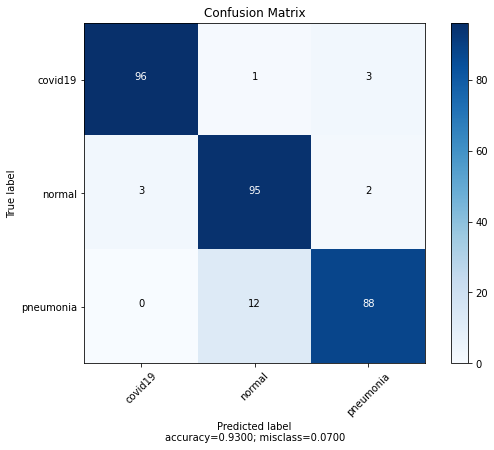

In [107]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal','pneumonia'],
                      title        = "Confusion Matrix")


In [110]:
torch.save(base_model.state_dict(), './best_model.pth')

In [111]:
# Loading the model pre-trained weights from saved file
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('./best_model.pth', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [112]:
import cv2
from torch.autograd import Variable

In [113]:
### transform after convert to jpg
data_transforms2 = transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])


In [114]:
def predict(img_path):
    image = Image.open(img_path)
    ##convert to jpg
    rgb_im = image.convert('RGB')
    image =rgb_im

    image_tensor = data_transforms2(image)
    image_tensor = image_tensor.unsqueeze_(0)
    print(image_tensor.size())
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

In [ ]:
!ls ./COVID19-DATASET/test/pneumonia/

torch.Size([1, 3, 150, 150])
Predicted: covid19


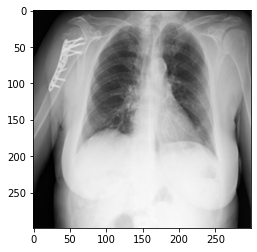

In [115]:
predict('./COVID19-DATASET/test/covid19/COVID-231.png') #Sample Image Path

torch.Size([1, 3, 150, 150])
Predicted: normal


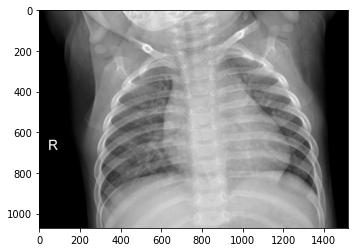

In [116]:
 predict('./COVID19-DATASET/test/normal/NORMAL2-IM-0395-0001-0001.jpeg') #Sample Image Path

torch.Size([1, 3, 150, 150])
Predicted: pneumonia


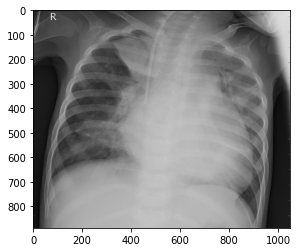

In [123]:
predict('./COVID19-DATASET/test/pneumonia/person1005_bacteria_2936.jpeg') #Sample Image Path